<a href="https://colab.research.google.com/github/armelyara/drgreen/blob/main/drgreen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf
import keras

import os
import numpy as np
import PIL
from PIL import Image
import glob
import matplotlib.pyplot as plt
import zipfile

from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop



In [2]:
os.environ["KERAS_BACKEND"] = "tensorflow"

In [3]:
print(tf.__version__)

2.15.0



**DATA PROCESSING**

In [5]:
# Path to download dataset
local_zip = 'plantes.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('plantes')
zip_ref.close()

# Define the datasate path
base_dir = 'plantes/rename/'

In [6]:
# Directory with our training artemisia pictures
train_art_dir = os.path.join('plantes/rename/artemisia')
# Directory with our training carica pictures
train_cari_dir = os.path.join('plantes/rename/carica')
# Directory with our training goyavier pictures
train_goya_dir = os.path.join('plantes/rename/goyavier')
# Directory with our training kinkeliba pictures
train_kink_dir = os.path.join('plantes/rename/kinkeliba')

In [7]:
train_art_names = os.listdir(train_art_dir)
print(train_art_names[:10])
train_cari_names = os.listdir(train_cari_dir)
print(train_cari_names[:10])
train_goya_names = os.listdir(train_goya_dir)
print(train_goya_names[:10])
train_kink_names = os.listdir(train_kink_dir)
print(train_kink_names[:10])

['arte_82.jpg', 'arte_185.jpg', 'arte_210.jpg', 'arte_39.jpg', 'arte_214.jpeg', 'arte_101.jpg', 'arte_223.jpg', 'arte_97.jpg', 'arte_121.jpg', 'arte_233.jpg']
['74.Figuier-Ficus-carica-bourgeon-et-feuille-arbres-fruitiers.jpg', '270.figuier-variete-ronde-de-bordeaux-ficus-carica.jpg', '202.ficus-carica-prebonsai-19-ans-figuier.jpg', '455.carica_papaya_06.jpg', '4.GBPIX_photo_9097.jpg', 'car_54.jpg', 'car_9.jpg', '193.papayer_papaye_03.jpg', '282.papayer-fleurs-th.jpg', '465.figuier-ice-chrystal-.jpg']
['489.8b08a3779d8f061e704455994f4c985b.jpg', '281.psidium-guajava1.jpg', '57.psidium-cattleianum-goyavier-fraise-600x450.jpg', '589.feuille_avocatier-6a850.jpg', '275.feuille_manguier_2-72169.jpg', '625.ekzoticheskoerastenieguavakakv.jpg', '340.psidium-guajava2roftk.jpg', '165.psidium-guajava3.jpg', '274.psidium_guajava_nana_01.jpg', '246.vert-fruits-goyave-psidium-guajava.jpg']
['105.543bf4eeb36f7_Kinkeliba_combretum_feuilles_zoom_plante_medicinale_michel_pierre_herboristerie_du_palais_r

In [8]:
print('total training artemisia images:', len(os.listdir(train_art_dir)))
print('total training carica images:', len(os.listdir(train_cari_dir)))
print('total training goyavier images:', len(os.listdir(train_goya_dir)))
print('total training kinkeliba images:', len(os.listdir(train_kink_dir)))

total training artemisia images: 250
total training carica images: 357
total training goyavier images: 218
total training kinkeliba images: 293


In [9]:
# Parameters for the loader
batch_size = 64
img_height = 224
img_width = 224

In [10]:
# Split the dataset in training & validation set
train_pl = tf.keras.utils.image_dataset_from_directory(
  base_dir,
  subset="training",
  validation_split=0.2,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


val_pl = tf.keras.utils.image_dataset_from_directory(
  base_dir,
  subset="validation",
  validation_split=0.2,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1115 files belonging to 4 classes.
Using 892 files for training.
Found 1115 files belonging to 4 classes.
Using 223 files for validation.


In [11]:
# Find the class names using class_names attribut
class_names = train_pl.class_names
print(class_names)

['artemisia', 'carica', 'goyavier', 'kinkeliba']


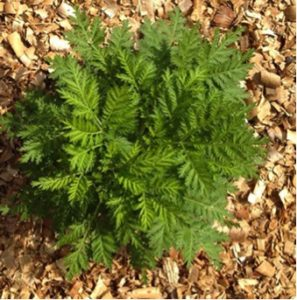

In [12]:
# Show any artemisia image
artemisia = list(glob.glob(base_dir + 'artemisia/*'))
PIL.Image.open(str(artemisia[1]))

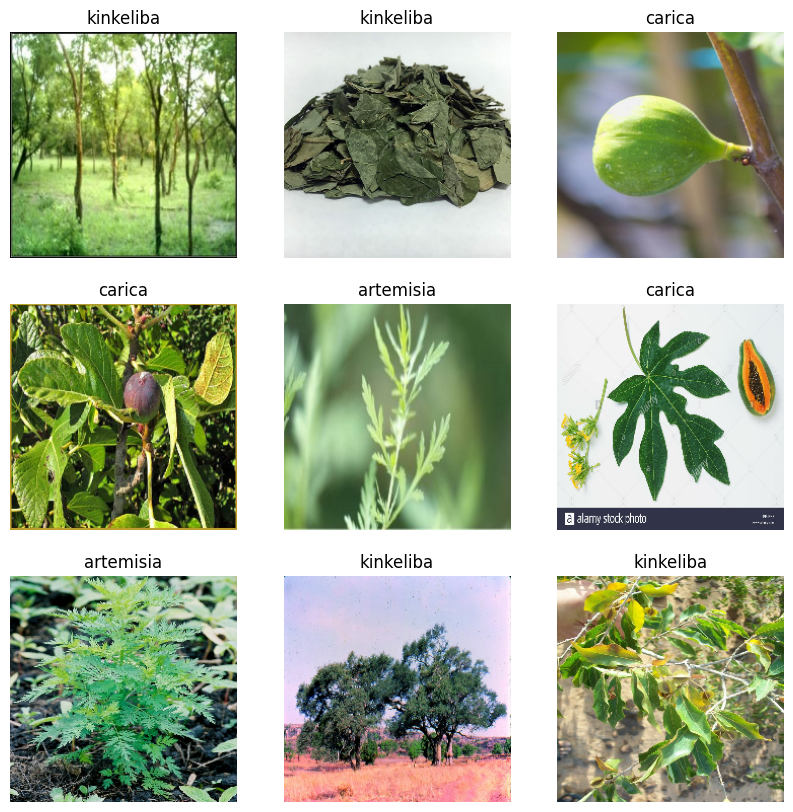

In [13]:
# Visualize the data. Here you will see the first nine images from the training dataset

plt.figure(figsize=(10, 10))

for images, labels in train_pl.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
# Count the total number of image in the dataset
image_count = len(list(glob.glob(base_dir + '*/*')))
print(image_count)

1118


In [15]:
# Iterate over the dataset and retrieve batches of images
for image_batch, labels_batch in train_pl:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 224, 224, 3)
(64,)


In [16]:
# Overlaps data preprocessing and model execution while training
AUTOTUNE = tf.data.AUTOTUNE

train_pl = train_pl.cache().prefetch(buffer_size=AUTOTUNE)
val_pl = val_pl.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
# Standardize Data
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [18]:
normalized_ds = train_pl.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [19]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

In [20]:
num_classes = 4

pretrained_base = tf.keras.applications.Xception(input_shape=[224, 224, 3], include_top=False)

pretrained_base.trainable = True

model = tf.keras.models.Sequential([
    #data_augmentation,
    pretrained_base,
    tf.keras.layers.GlobalAveragePooling2D(),
    # Note the input shape is the desired size of the image 128x128 with 3 bytes color
    # This is the first convolution
    #tf.keras.layers.Conv2D(8, (3,3), activation='relu', input_shape=(224, 224, 3), padding='same'),
    #tf.keras.layers.MaxPooling2D(),
    #tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.BatchNormalization(),
    # The second convolution
    #tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    #tf.keras.layers.MaxPooling2D(),
    #tf.keras.layers.Dropout(0.3),
    #tf.keras.layers.BatchNormalization(),
    # The third convolution
    #tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    #tf.keras.layers.MaxPooling2D(),
    #tf.keras.layers.Dropout(0.3),
    #tf.keras.layers.BatchNormalization(),
    # The fouth convolution
    #tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    #tf.keras.layers.MaxPooling2D(),
    #tf.keras.layers.Dropout(0.3),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    # Flatten the results to feed into a DNN
    #tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    #tf.keras.layers.Dense(90, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='sigmoid', dtype=tf.float32)
])

83683744/83683744 [==============================] - 1s 0us/step


In [21]:
# Show model parameters
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                                 
Total params: 20869676 (79.61 MB)
Trainable params: 20815148 (79.40 MB)
Non-trainable params: 54528 (213.00 KB)
_________________________________________________________________


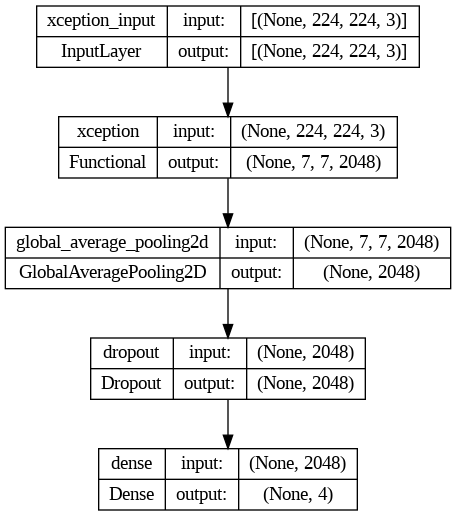

In [22]:
import tensorflow as tf # Assuming you're using TensorFlow
from keras.utils import plot_model
# Assuming you have your Keras model defined as 'model'
plot_model(model, to_file='cnn_plot.png', show_shapes=True, show_layer_names=True)

In [23]:
model.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(),
              #optimizer='adam',
              optimizer=tf.keras.optimizers.legacy.SGD(
              learning_rate=0.01,
              momentum=0.9,
              decay=0.01
              ),
              metrics=['acc'])

In [24]:
# Add early stopping to the model
#early_stopping = tf.keras.callbacks.EarlyStopping(patience=5)
# Training model
epochs = 5
history = model.fit(
      train_pl,
      validation_data=val_pl,
      epochs=epochs
      #callbacks=[early_stopping]
      )

Epoch 1/5
14/14 [==============================] - 964s 68s/step - loss: 1.3237 - acc: 0.3363 - val_loss: 1.4436 - val_acc: 0.3767
Epoch 2/5
14/14 [==============================] - 891s 64s/step - loss: 0.8209 - acc: 0.7365 - val_loss: 1.0607 - val_acc: 0.5247
Epoch 3/5
14/14 [==============================] - 884s 63s/step - loss: 0.4772 - acc: 0.8778 - val_loss: 0.8710 - val_acc: 0.6368
Epoch 4/5
14/14 [==============================] - 874s 63s/step - loss: 0.2866 - acc: 0.9518 - val_loss: 0.8043 - val_acc: 0.6726
Epoch 5/5
14/14 [==============================] - 897s 64s/step - loss: 0.1694 - acc: 0.9843 - val_loss: 0.7555 - val_acc: 0.7085


Build a sequential model with Keras API.

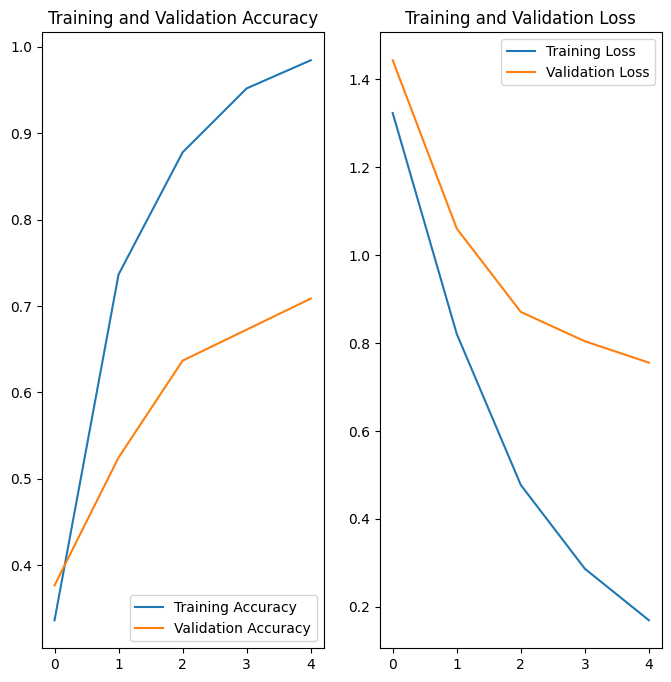

In [25]:
# Visualize training results
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
model.evaluate(val_pl, return_dict=True)

4/4 [==============================] - 55s 13s/step - loss: 0.7555 - acc: 0.7085


{'loss': 0.755530595779419, 'acc': 0.7085201740264893}

In [27]:
def get_actual_predicted_labels(dataset):
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [28]:
import seaborn as sns
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')

  # Set the number of ticks to match the number of labels
  ax.set_xticks(range(len(labels)))
  ax.set_yticks(range(len(labels)))
  # Set the labels for the ticks
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [37]:
!pip install keras-video-generators

In [43]:
from keras_video import VideoFrameGenerator
# Assuming 'plantes/rename/' is the intended directory for training data
base_dir = {'train': 'plantes/rename/'}  # Convert base_dir to a dictionary
n_frames = 10  # Number of frames to extract from each video
fg = VideoFrameGenerator(base_dir['train'], n_frames, training=True)
labels_list = list(fg.class_ids_for_name.keys())

Please check if the path is OK, and if the glob pattern is correct.
See https://docs.python.org/3/library/glob.html


Total data: 0 classes for 0 files for train


AttributeError: 'VideoFrameGenerator' object has no attribute 'class_ids_for_name'

In [34]:
actual, predicted = get_actual_predicted_labels(train_pl)
plot_confusion_matrix(actual, predicted, labels, 'training')

14/14 [==============================] - 212s 15s/step


TypeError: Cannot convert '' to EagerTensor of dtype int32

Error in callback <function _draw_all_if_interactive at 0x7cc3607ec9d0> (for post_execute):


TypeError: Cannot convert '' to EagerTensor of dtype int32

TypeError: Cannot convert '' to EagerTensor of dtype int32

<Figure size 640x480 with 2 Axes>

In [35]:
import sklearn.metrics

# Assuming you have a validation dataset 'val_pl'
actual, predicted = get_actual_predicted_labels(val_pl)

# Calculate precision, recall, and F1-score
precision = sklearn.metrics.precision_score(actual, predicted, average='weighted')
recall = sklearn.metrics.recall_score(actual, predicted, average='weighted')
f1_score = sklearn.metrics.f1_score(actual, predicted, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

4/4 [==============================] - 51s 12s/step
Precision: 0.7078581845768592
Recall: 0.7085201793721974
F1-score: 0.7018908846915222


In [36]:
# Test our model with another image unseen in training and validation set
import numpy as np

from google.colab import files
from keras.utils import load_img, img_to_array

uploaded=files.upload()

for fn in uploaded.keys():

  # predicting images
  path='/content/' + fn
  img= load_img(path, target_size=(224, 224))

  x=img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])

  plantes = model.predict(images, batch_size=64)

  print(plantes[0])

  if plantes.any():
    print(fn + "is an artemisia")

  elif plantes.any():
    print(fn + "is a goyavier")

  elif plantes.any():
    print(fn + " is a kinkeliba")

  else:
    print(fn + "is a carica")


Saving daucus carota.jpg to daucus carota.jpg
1/1 [==============================] - 1s 1s/step
[0.36687425 0.5829471  0.307375   0.84872454]
daucus carota.jpgis an artemisia


In [ ]:
# Convert and save model in TensorFlow Lite
saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('drgreen.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
# Download model
from google.colab import files

files.download('drgreen.tflite')
files.download('plants.txt')